<a href="https://colab.research.google.com/github/BayAreaMetro/mtc_wrangler/blob/main/momo_workshop/colab_Create_SF_network_from_OSM_GTFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMNS/Network Wrangler 2.0 Workshop - Building a San Francisco Network

This workshop workbook demonstrates how to use network_wrangler to create a base network from Open Streetmap (OSM) and a regional GTFS feed.

In addition to using the network_wrangler library, this notebook uses the script, [`create_mtc_network_from_OSM.py`](https://github.com/BayAreaMetro/mtc_wrangler/blob/main/create_baseyear_network/create_mtc_network_from_OSM.py). The script also contains a main method and works as a standalone tool, which would be more practical for building an actual network; this demonstration just uses the python notebook in order to illustrate the output of the major steps.


## Setup Environment

Fetch [network_wrangler code](https://github.com/BayAreaMetro/network_wrangler/tree/centroids) and [network creation script](https://github.com/BayAreaMetro/mtc_wrangler/blob/main/create_baseyear_network/create_mtc_network_from_OSM.py).
Currently the network_wrangler code is the centroids branch of a BayAreaMetro fork, but this will be merged into [`network_wrangler`](https://github.com/network-wrangler/network_wrangler) after review.

In [1]:
!git clone https://github.com/BayAreaMetro/network_wrangler.git
!git clone https://github.com/BayAreaMetro/mtc_wrangler.git

Cloning into 'network_wrangler'...
remote: Enumerating objects: 4242, done.
remote: Counting objects: 100% (1181/1181), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 4242 (delta 870), reused 767 (delta 755), pack-reused 3061 (from 2)
Receiving objects: 100% (4242/4242), 95.84 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (2703/2703), done.
Cloning into 'mtc_wrangler'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 470 (delta 10), reused 15 (delta 5), pack-reused 445 (from 1)
Receiving objects: 100% (470/470), 12.12 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (300/300), done.


Ensure `mtc_wrangler` code is up-to-date (we're fixing bugs!)

In [2]:
%cd /content/mtc_wrangler/
!git pull
print("Last commit for mtc_wrangler:")
!git log -1


/content/mtc_wrangler
Already up to date.
Last commit for mtc_wrangler:
commit 9cbfdce196804f4615913edd59c51d6bbcc461e6 (HEAD -> main, origin/main, origin/HEAD)
Author: jdahren <jahrenholtz@bayareametro.gov>
Date:   Thu Sep 11 20:16:21 2025 -0700

    Notebook with basic updated workflow


Ensure `network_wrangler` is on the `centroids` branch and up-to-date. Install package in editable mode.

In [3]:
%cd /content/network_wrangler/
!git pull
!git checkout centroids
print("Last commit for network_wrangler on centroids branch:")
!git log -1

/content/network_wrangler
Already up to date.
Branch 'centroids' set up to track remote branch 'centroids' from 'origin'.
Switched to a new branch 'centroids'
Last commit for network_wrangler on centroids branch:
commit 949460d90feb5379f7129c1dc7422564d2ba8a8d (HEAD -> centroids, origin/centroids)
Merge: 7adcd50 aeaab3f
Author: Lisa Zorn <lzorn@bayareametro.gov>
Date:   Thu Sep 11 18:01:28 2025 -0700

    Merge remote-tracking branch 'origin/main' into centroids


## Install python packages and test import
This includes `scikit-learn`, `pygris`, and local version of `network_wrangler`

In [4]:
%%capture python_install_cap
!pip install scikit-learn pygris
# Install Tableau package if using Tableau for visualization
#!pip install tableauhyperapi
%cd /content/network_wrangler/
!pip install -e .

In [5]:
# run this if you want to see the output from the python install
print(python_install_cap)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
/content/network_wrangler
Obtaining file:///content/network_wrangler
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 22.4 MB/s eta 0:00:00
   ━━

In [6]:
# make sure we can import network_wrangler
import network_wrangler
import pprint
print(pprint.pformat(dir(network_wrangler)))

/content/network_wrangler/network_wrangler/utils/utils.py:54: SyntaxWarning: invalid escape sequence '\ '
  return re.sub("[\ ]+", delimiter, text)


['DictQueryAccessor',
 'Isin_dict',
 'MIN_PROJECT_CARD_SCHEMA_VERSION',
 'MIN_ROADWAY_NETWORK_SCHEMA_VERSION',
 'MIN_TRANSIT_NETWORK_SCHEMA_VERSION',
 'Scenario',
 'SelectionError',
 'TARGET_PROJECT_CARD_SCHEMA_VERSION',
 'TARGET_ROADWAY_NETWORK_SCHEMA_VERSION',
 'TARGET_TRANSIT_NETWORK_SCHEMA_VERSION',
 'WranglerLogger',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'configs',
 'create_scenario',
 'dfHash',
 'dict_to_query',
 'errors',
 'hashlib',
 'isin_dict',
 'load_roadway',
 'load_roadway_from_dataframes',
 'load_roadway_from_dir',
 'load_scenario',
 'load_transit',
 'load_wrangler_config',
 'logger',
 'models',
 'params',
 'pd',
 'roadway',
 'scenario',
 'setup_logging',
 'time',
 'transit',
 'utils',
 'warnings',
 'write_roadway',
 'write_transit']


## Fetch public GTFS Input files from Google Drive
This is the regional transit feed for the San Francisco Bay Area, provided by [511 SF Bay’s Portal for Open Transit Data](https://511.org/open-data/transit). This was downloaded on October 2, 2024 via `http://api.511.org/transit/datafeeds?api_key=[my_api_key]&operator_id=RG&historic=2023-09`


In [7]:
%cd /content/
!mkdir BayArea_511gtfs_2023-09
%cd /content/BayArea_511gtfs_2023-09
!gdown 1wu-echoNNi5NzQh3BT4RwfnHYlUg8ZK5
!unzip BayArea_511gtfs_2023-09.zip

/content
/content/BayArea_511gtfs_2023-09
Downloading...
From (original): https://drive.google.com/uc?id=1wu-echoNNi5NzQh3BT4RwfnHYlUg8ZK5
From (redirected): https://drive.google.com/uc?id=1wu-echoNNi5NzQh3BT4RwfnHYlUg8ZK5&confirm=t&uuid=03c21a49-4c6d-424c-afe4-17f8b8c49292
To: /content/BayArea_511gtfs_2023-09/BayArea_511gtfs_2023-09.zip
100% 123M/123M [00:01<00:00, 86.0MB/s]
Archive:  BayArea_511gtfs_2023-09.zip
  inflating: routes.txt              
  inflating: stops.txt               
  inflating: pathways.txt            
  inflating: shapes.txt              
  inflating: transfers.txt           
  inflating: directions.txt          
  inflating: calendar_dates.txt      
  inflating: agency.txt              
  inflating: levels.txt              
  inflating: trips.txt               
  inflating: stop_times.txt          


## Setup Logging
We have both info and debug logging. Info logs are high-level and will get reported to stdout, while debug logs are very detailed and will only be logged to the debug log file.

In [8]:
%cd /content/
from network_wrangler import WranglerLogger
import pathlib
info_log_file = pathlib.Path("create_SF_network_info.log")
debug_log_file = pathlib.Path("create_SF_network_debug.log")
network_wrangler.setup_logging(
    info_log_file,
    debug_log_file,
    std_out_level="info",
    file_mode="w"
  )

# We have custom loggers and we want to prevent their messages from being
# processed by the root logger's handlers (if any remain)
WranglerLogger.propagate = False

# this one will just go to the debug file
WranglerLogger.debug("Debug test")
# this will go to the console (stdout) and the info & debug files
WranglerLogger.info("Info test")

/content
2025-09-12 04:27:13, INFO: Info test


In [9]:
!tail /content/create_SF_network_debug.log

2025-09-12 04:27:13, DEBUG: Debug test
2025-09-12 04:27:13, INFO: Info test


## Create output directory and import script code

In [11]:
%cd /content/mtc_wrangler/create_baseyear_network
from create_mtc_network_from_OSM import (
  step1_download_osm_network,
  stepa_standardize_attributes,
  step2_simplify_network_topology,
  step3_assign_county_node_link_numbering,
  step4_add_centroids_and_connectors,
  step5_prepare_gtfs_transit_data,
  step6_create_transit_network
)
%cd /content/mtc_wrangler/momo_workshop
from visualization import *

OUTPUT_DIR = pathlib.Path("/content/output_SF_OSM")
OUTPUT_DIR.mkdir(exist_ok=True)

/content/mtc_wrangler/create_baseyear_network
/content/mtc_wrangler/momo_workshop


## Step 1: Download OSM network data

This downloads the Open Street Map data for San Francisco county using [osmnx](https://osmnx.readthedocs.io/)

In [12]:
# Download the OSM network data for San Francisco county
osm_g = step1_download_osm_network("San Francisco", OUTPUT_DIR)
print(type(osm_g))

2025-09-12 04:29:36, INFO: ======= STEP 1: Download OSM network for San Francisco =======
2025-09-12 04:29:36, INFO: Downloading network for San Francisco...
2025-09-12 04:31:05, INFO: Cached OSM graph to /content/output_SF_OSM/1_graph_OSM_SanFrancisco.pkl
2025-09-12 04:31:05, INFO: Downloaded graph has 169,335 edges and 57,674 nodes
<class 'networkx.classes.multidigraph.MultiDiGraph'>


## Step 1a: standardize attributes for the roadway network
Optionally write it, if output format arguments are specified.

In [13]:
links_unsimplified_gdf, nodes_unsimplified_gdf = stepa_standardize_attributes(
    osm_g, "San Francisco", "1a_original_", OUTPUT_DIR, []
  )

2025-09-12 04:31:50, INFO: ======= STEP 1a: Standardize attributes for San Francisco =======
2025-09-12 04:32:07, INFO: After converting to gdfs, len(edges_gdf)=169,335 and len(nodes_gdf)=57,674
2025-09-12 04:32:07, INFO: links_gdf has 169,020 links after dropping loop links (with u==v)
2025-09-12 04:32:20, INFO: Filling 146,843 links with missing lane counts using highway type mapping
2025-09-12 04:32:21, INFO: Found 224 links with missing lanes, assuming 1 lane
2025-09-12 04:32:21, INFO: After standardize_lanes_value:
lanes
0    91610
1    65072
2    10212
3     1772
4      260
5       91
6        3
Name: count, dtype: int64
2025-09-12 04:32:21, INFO: buslanes:
buslanes
0    168522
1       498
Name: count, dtype: int64
2025-09-12 04:32:21, INFO: Handling links with duplicate (A,B)
2025-09-12 04:32:21, INFO: Removing 16,746 nameless service links


## Step 2: Simplify network topology
This consolidates intersections while preserving connectivity.

In [16]:
simplified_g = step2_simplify_network_topology(osm_g, "San Francisco", OUTPUT_DIR)
print(type(osm_g))

2025-09-12 04:33:30, INFO: ======= STEP 2: Simplify network topology for San Francisco =======
2025-09-12 04:33:41, INFO: Simplifying with tolerance=20 feet...
2025-09-12 04:34:53, INFO: Cached simplified graph to /content/output_SF_OSM/2_graph_OSM_SanFrancisco_simplified20.pkl
2025-09-12 04:34:54, INFO: Simplified graph has 91,669 edges and 25,662 nodes
<class 'networkx.classes.multidigraph.MultiDiGraph'>


Summarize some of the differences between the original and simplified.

=== Network Comparison: Original OSM vs Simplified OSM ===

📊 BASIC STATISTICS
Nodes: 57,674 → 25,662 (44.5% remaining)
Edges: 169,335 → 91,669 (54.1% remaining)
Nodes removed: 32,012 (55.5%)
Edges removed: 77,666 (45.9%)

🔗 CONNECTIVITY ANALYSIS
Average degree: 5.87 → 7.14
Max degree: 16 → 46

Degree 2 nodes (typical street continuation): 6,502 → 4,000
Degree 3 nodes (T-intersections): 1,543 → 839
Degree 4+ nodes (complex intersections): 49,547 → 20,795

📏 EDGE LENGTH ANALYSIS
Average edge length: 42.8m → 209.4m
Total network length: 7253.1km → 19199.2km
Shortest edge: 0.0m → 12.2m
Longest edge: 3697.1m → 12131.6m


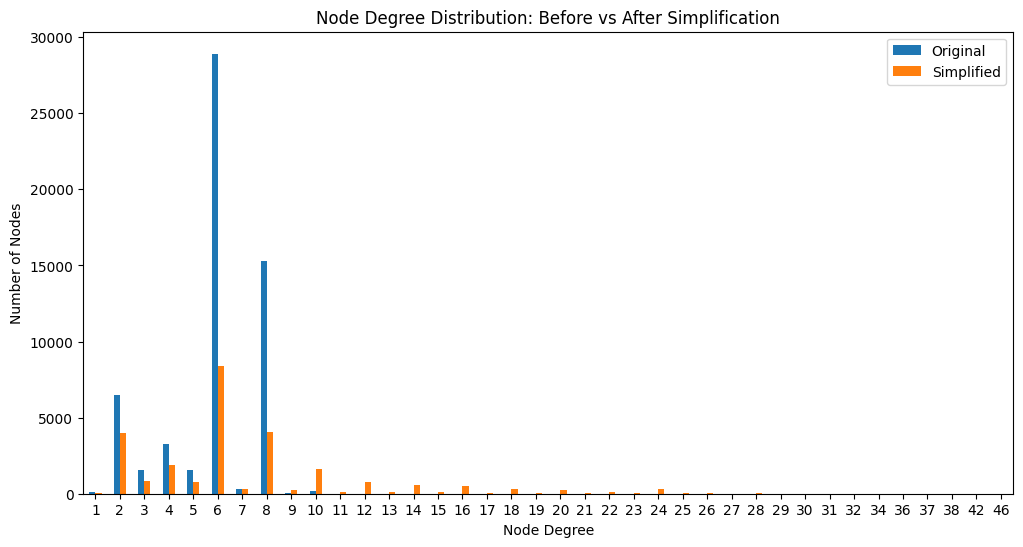

In [18]:
compare_original_and_simplified_networks(osm_g, simplified_g)
# Plot node degree changes original vs simplified
plot_node_degree_changes(osm_g, simplified_g)

# Step 2a: standardize attributes for the roadway network
Optionally write it, if output format arguments are specified.

In [19]:
links_gdf, nodes_gdf = stepa_standardize_attributes(
    simplified_g, "San Francisco",
    prefix="2a_simplified",
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
  )


2025-09-12 04:35:35, INFO: ======= STEP 2a: Standardize attributes for San Francisco =======
2025-09-12 04:35:46, INFO: After converting to gdfs, len(edges_gdf)=91,669 and len(nodes_gdf)=25,662
2025-09-12 04:35:46, INFO: links_gdf has 91,354 links after dropping loop links (with u==v)
2025-09-12 04:35:52, INFO: Filling 77,569 links with missing lane counts using highway type mapping
2025-09-12 04:35:53, INFO: Found 183 links with missing lanes, assuming 1 lane
2025-09-12 04:35:53, INFO: After standardize_lanes_value:
lanes
1    42990
0    39849
2     4681
3     3506
4      243
5       83
6        2
Name: count, dtype: int64
2025-09-12 04:35:53, INFO: buslanes:
buslanes
0    91133
1      221
Name: count, dtype: int64
2025-09-12 04:35:53, INFO: Handling links with duplicate (A,B)
2025-09-12 04:35:53, INFO: Removing 11,130 nameless service links
2025-09-12 04:36:01, INFO: Wrote /content/output_SF_OSM/2a_simplifiedSanFrancisco_links.geojson
2025-09-12 04:36:02, INFO: Wrote /content/output_

## Step 3: Assign county-specific numbering and create [RoadwayNetwork](https://bayareametro.github.io/network_wrangler/main/api/#network_wrangler.roadway.network.RoadwayNetwork) instance.
This also drops OSM columns we've translated into standard columns and writes the roadway network

In [20]:
roadway_network = step3_assign_county_node_link_numbering(
    links_gdf, nodes_gdf,
    county="San Francisco",
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
)

2025-09-12 04:36:02, INFO: ======= STEP 3: Create roadway network with county numbering for San Francisco =======
2025-09-12 04:36:15, INFO: Saved roadway network in geojson format
2025-09-12 04:36:15, INFO: Created roadway network with 64637 links and 25662 nodes


## Step 4: Add centroids and centroid connectors
This modifies the roadway_network in place.

In [21]:
step4_add_centroids_and_connectors(
    roadway_network,
    county="San Francisco",
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
)

2025-09-12 04:36:15, INFO: ======= STEP 4: Create centroids and centroid connectors for San Francisco =======
2025-09-12 04:36:15, INFO: Looking for MTC zones files in /content/output_SF_OSM/mtc_zones
2025-09-12 04:36:16, INFO: Succeeded downloading /content/output_SF_OSM/mtc_zones/mazs_tazs_county_2.5.csv
2025-09-12 04:36:20, INFO: Succeeded downloading /content/output_SF_OSM/mtc_zones/mazs_TM2_2_5.shp
2025-09-12 04:36:20, INFO: Read MAZ shapefile from /content/output_SF_OSM/mtc_zones/mazs_TM2_2_5.shp
2025-09-12 04:36:23, INFO: Succeeded downloading /content/output_SF_OSM/mtc_zones/tazs_TM2_2_5.shp
2025-09-12 04:36:24, INFO: Read TAZ shapefile from /content/output_SF_OSM/mtc_zones/tazs_TM2_2_5.shp
2025-09-12 04:36:24, INFO: Filtered MAZ to San Francisco: 4,153 rows
2025-09-12 04:36:24, INFO: Filtered TAZ to San Francisco: 635 rows
2025-09-12 04:36:24, INFO: Added node centroids for TAZ: increased size of nodes_df from 25,662 to 26,297
2025-09-12 04:36:24, INFO: Adding centroid connect

## Step 5: Prepare GTFS transit data
Read and filter to service date, relevant operators. Creates [GtfsModel](https://bayareametro.github.io/network_wrangler/main/api_transit/#network_wrangler.models.gtfs.gtfs.GtfsModel) instance.


In [22]:
gtfs_model = step5_prepare_gtfs_transit_data(
    county="San Francisco",
    input_gtfs=pathlib.Path("/content/BayArea_511gtfs_2023-09"),
    output_dir=OUTPUT_DIR
)

2025-09-12 04:37:22, INFO: ======= STEP 5: Preparing GTFS transit data for San Francisco =======
2025-09-12 04:37:22, INFO: Loading GTFS feed for September 27, 2023...
2025-09-12 04:37:25, INFO: Reading GTFS feed tables from /content/BayArea_511gtfs_2023-09
2025-09-12 04:37:59, INFO: Initializing agency
2025-09-12 04:37:59, INFO: Initializing routes
2025-09-12 04:37:59, INFO: Initializing shapes
2025-09-12 04:38:01, INFO: Initializing stops
2025-09-12 04:38:01, INFO: Initializing trips
2025-09-12 04:38:02, INFO: Initializing stop_times
2025-09-12 04:41:19, INFO: Filtering feed to 29,509 service_ids
2025-09-12 04:41:23, INFO: Filtered trips from 320,483 to 29,509
2025-09-12 04:41:30, INFO: Preserving 160 parent stations referenced by kept stops
2025-09-12 04:41:30, INFO: All stop_times entries have valid stop_ids after filtering
2025-09-12 04:41:31, INFO: Initializing agency
2025-09-12 04:41:31, INFO: Initializing routes
2025-09-12 04:41:31, INFO: Initializing shapes
2025-09-12 04:41:31

## Step 6: Create TransitNetwork by integrating GtfsModel with RoadwayNetwork
This updates the tables in the [GtfsModel](https://bayareametro.github.io/network_wrangler/main/api_transit/#network_wrangler.models.gtfs.gtfs.GtfsModel) instance so they're wrangler-flavored, where nodes refer to the [RoadwayNetwork](https://bayareametro.github.io/network_wrangler/main/api/#network_wrangler.roadway.network.RoadwayNetwork)  instance. For bus routes, this means "snapping" stops to existing nodes; for other types of transit, this means creating nodes and links in the roadway network that transit-specific. With this done, a Wrangler-flavored [Feed](https://bayareametro.github.io/network_wrangler/main/api_transit/#network_wrangler.transit.feed.feed.Feed) instance can be created and incorporated into a [TransitNetwork](https://bayareametro.github.io/network_wrangler/main/api/#network_wrangler.transit.network.TransitNetwork) instance.


In [23]:
transit_network = step6_create_transit_network(
    gtfs_model,
    roadway_network,
    county="San Francisco",
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
)

2025-09-12 04:47:12, INFO: ======= STEP 6: Creating Wrangler-flavored GTFS Feed for San Francisco =======
2025-09-12 04:47:16, INFO: Creating frequencies table from feed stop_times data
2025-09-12 04:47:16, INFO: There are 315 unique shape_ids.
2025-09-12 04:47:16, INFO: These will serve as our new trip_ids.
2025-09-12 04:47:21, INFO: Matching stops to shape points using vectorized approach
2025-09-12 04:47:21, INFO: Finding stops for 315 unique shape_ids
2025-09-12 04:48:15, INFO: Finished adding stop information to shapes
2025-09-12 04:48:15, INFO: Matching 3,005 bus stops to roadway nodes
2025-09-12 04:48:18, INFO: Found 3,005 valid matches out of 3,005 total bus stops
2025-09-12 04:48:19, INFO: Adding transit stations and station-based links to the roadway network
2025-09-12 04:48:22, INFO: Adding 415 nodes to roadway network
2025-09-12 04:48:24, INFO: Adding 500 links to roadway network
2025-09-12 04:48:25, INFO: Adding 500 shapes to roadway network
2025-09-12 04:48:25, INFO: Crea

## Step 7: Create [Scenario](https://bayareametro.github.io/network_wrangler/main/api/#network_wrangler.scenario.Scenario)

This is ready for for project cards to be applied, so a future scenario (and alternative scenarios) can be created.


In [24]:
my_scenario = network_wrangler.scenario.create_scenario(
    base_scenario = {
        "road_net": roadway_network,
        "transit_net": transit_network,
        "applied_projects": [],
        "conflicts": {}
    },
)

# write it to disk
scenario_dir = OUTPUT_DIR / "7_wrangler_scenario"
scenario_dir.mkdir(exist_ok=True)
my_scenario.write(
    path=scenario_dir,
    name="mtc_2023",
    roadway_file_format="geojson",
    roadway_true_shape=True
)
WranglerLogger.info(f"Wrote scenario to {scenario_dir}")


2025-09-12 04:48:45, INFO: Creating Scenario
2025-09-12 04:49:10, INFO: Wrote 7 TransitNetwork tables to /content/output_SF_OSM/7_wrangler_scenario/transit
2025-09-12 04:49:10, INFO: Wrote scenario to /content/output_SF_OSM/7_wrangler_scenario
